<a href="https://colab.research.google.com/github/ArturoRM22/drone_agents/blob/main/Current_CamerasModel_WithPlots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs

In [255]:
#Instalador de las librerias necesarias
#
#!pip install owlready2 agentpy seaborn numpy
#

In [256]:
# Model design
from owlready2 import *
import agentpy as ap
import numpy as np

# Visualization
import seaborn as sns

#Pathfinding
import math
import heapq

#Misc
from matplotlib import pyplot as plt
import IPython
import random

# Assistance Functions (Pathfinding, Grid Sizes, Etc.)

In [257]:
def heuristic(a,b):
  #Distancia de Manhattan, resta el valor absoluto de la XY axtual con la XY destino
  # a[0] = x inicial
  # b[0] = x final
  # a[1] = y inicial
  # b[1] = y final
  return abs(a[0] - b[0]) + abs(a[1] - b[1])

def get_neighbors(grid,node):
  neighbors = []


  x,y = node

  if x > 0:
    neighbors.append((x-1,y))

  if x < grid.shape[0] - 1:
    neighbors.append((x+1,y))

  if y > 0:
    neighbors.append((x,y-1))

  if y < grid.shape[1] -1:
    neighbors.append((x,y+1))

  return neighbors


# Ontology

Correr la ontologia **SOLO UNA VEZ** ,si da problemas usar el comando de borrar y volver a crearla

In [258]:
"""
#Creamos la ontologia
onto = get_ontology("file://ontologia.owl")


with onto:
  class Entity(Thing):
    pass

  class Camera(Entity):
    pass

  class Drone(Entity):
    pass

  class Intruder(Entity):
    pass

  class Guard(Entity):
    pass

  class Box(Entity):
    pass

  class Place(Thing):
    pass

  #Relaciones de posicion
  class is_in_place(ObjectProperty, FunctionalProperty):
      domain = [Entity]
      range = [Place]

  class at_position(DataProperty,FunctionalProperty):
        domain = [Place]
        range = [str]

  #Relaciones Camara

  class has_seen_intruder(ObjectProperty, FunctionalProperty):
    domain = [Camera]
    range = [Intruder]

  #Relaciones Dron

  class is_following_intruder(ObjectProperty, FunctionalProperty):
    domain = [Drone]
    range = [Intruder]

  class is_called_by_camera(ObjectProperty, FunctionalProperty):
    domain = [Drone]
    range = [Camera]

  #Relaciones Intruso

  class has_been_detected(DataProperty,FunctionalProperty):
    domain = [Intruder]
    range = [bool]

  class has_targets(DataProperty,FunctionalProperty):
    domain = [Intruder]
    range = [str]

  class is_hostile(DataProperty,FunctionalProperty):
    domain = [Intruder]
    range = [str]

  #Relaciones Guardia de seguridad

  class has_drone(ObjectProperty,FunctionalProperty):
    domain = [Guard]
    range = [Drone]

  # New relationship for inspecting intruders
  class is_inspecting_intruder(ObjectProperty, FunctionalProperty):
      domain = [Guard]
      range = [Intruder]
"""

'\n#Creamos la ontologia\nonto = get_ontology("file://ontologia.owl")\n\n\nwith onto:\n  class Entity(Thing):\n    pass\n\n  class Camera(Entity):\n    pass\n\n  class Drone(Entity):\n    pass\n\n  class Intruder(Entity):\n    pass\n\n  class Guard(Entity):\n    pass\n\n  class Box(Entity):\n    pass\n\n  class Place(Thing):\n    pass\n\n  #Relaciones de posicion\n  class is_in_place(ObjectProperty, FunctionalProperty):\n      domain = [Entity]\n      range = [Place]\n\n  class at_position(DataProperty,FunctionalProperty):\n        domain = [Place]\n        range = [str]\n\n  #Relaciones Camara\n\n  class has_seen_intruder(ObjectProperty, FunctionalProperty):\n    domain = [Camera]\n    range = [Intruder]\n\n  #Relaciones Dron\n\n  class is_following_intruder(ObjectProperty, FunctionalProperty):\n    domain = [Drone]\n    range = [Intruder]\n\n  class is_called_by_camera(ObjectProperty, FunctionalProperty):\n    domain = [Drone]\n    range = [Camera]\n\n  #Relaciones Intruso\n\n  class

In [259]:
#Delete just in case
#onto.destroy(update_relation = True, update_is_a = True)

# Messages class

In [260]:
class Message:
    def __init__(self, sender, receiver, content):
        self.sender = sender
        self.receiver = receiver
        self.content = content

# Camera Agent

In [261]:
class CameraAgent(ap.Agent):

  """
    <-- Funciones de Ejecucion -->
  """

  """
    Funcion de Setup
  """

  def setup(self):
    self.agentType = 0
    self.firstStep = True
    self.neighbors = []

    self.actions = (
      self.check_for_intruder,
    )

    self.rules = (
      self.check_for_intruder_rule,
    )


  """
    Funcion de See
  """
  def see(self, e):

    #Vemos los vecinos de la camara
    self.neighbors = e.neighbors(self,5)

  """
    Funcion de Next
  """
  def next(self):
    for act in self.actions:
      for rule in self.rules:
        if rule(act):
          act()

  """
    Funcion de Paso
  """

  def step(self):
    if self.firstStep:
      self.firstStep = False
      place = self.model.grid.positions[self]
      self.this_camera = Camera(is_in_place=Place(at_position=str(place)),
                                    has_seen_intruder = None )

      #self.the_drone = self.model.drones[0].this_drone #Since there is just one drone


    self.see(self.model.grid)
    self.next()

    """
    for neighbor in self.neighbors:
      print(self.model.grid.positions[neighbor])
    """

  """
    Funcion de Update
  """

  def update(self):
    pass

  """
    Funcion de End
  """

  def end(self):
    pass

  """
    <-- Acciones -->
  """

  def check_for_intruder(self):
      for neighbor in self.neighbors:
          if neighbor.agentType == 2:  # Intruder detected
              self.this_camera.has_seen_intruder = neighbor.this_intruder
              # Broadcast a message to notify the intruder about detection
              message = Message(sender = self.this_camera, receiver="Intruder", content="Detected")
              self.model.messages.append(message)

              # Broadcast a message to notify the drone about detection
              message = Message(sender = self.this_camera, receiver="Drone", content=neighbor.this_intruder)
              self.model.messages.append(message)

              self.model.whoDetected = self.id
              """
              message = Message(sender = self.this_camera, receiver="Drone", content=self.this_camera)
              self.model.messages.append(message)
              """

  """
    <-- Reglas -->
  """

  def check_for_intruder_rule(self, act):
    validator = [False, False]

    if self.this_camera.has_seen_intruder == None:
      validator[0] = True

    if act == self.check_for_intruder:
      validator[1] = True

    return sum(validator) == 2

# Drone Agent

In [262]:
class DroneAgent(ap.Agent):

  """
    <-- Funciones de Ejecucion -->
  """

  """
    Funcion de Setup
  """

  def setup(self):
    self.firstStep = True
    self.agentType = 1
    #Variables de patrulla
    self.path_counter = 0
    self.path = [
        # Camino de patrullaje
        (24, 10), (24, 11), (24, 12), (24, 13), (24, 14), (24, 15), (24, 16), (24, 17), (24, 18), (24, 19), (24, 20), (24, 21), (24, 22), (24, 23),
        (23, 23), (22, 23), (21, 23), (20, 23), (19, 23), (18, 23), (17, 23),
        (17, 22), (17, 21), (17, 20), (17, 19), (17, 18),
        (18, 18), (19, 18), (20, 18), (21, 18), (22, 18), (23, 18), (24, 18),
        (24, 17), (24, 16), (24, 15), (24, 14),
        (23, 14), (22, 14), (21, 14), (20, 14), (19, 14), (18, 14), (17, 14), (16, 14), (15, 14), (14, 14), (13, 14),
        (13, 15), (13, 16), (13, 17), (13, 18), (13, 19), (13, 20), (13, 21), (13, 22), (13, 23),
        (12, 23), (11, 23), (10, 23), (9, 23), (8, 23), (7, 23), (6, 23), (5, 23), (4, 23), (3, 23), (2, 23), (1, 23),
        (1, 22), (1, 21), (1, 20), (1, 19), (1, 18), (1, 17), (1, 16), (1, 15), (1, 14), (1, 13), (1, 12), (1, 11), (1, 10),
        (2, 10), (3, 10), (4, 10), (5, 10), (6, 10), (7, 10), (8, 10), (9, 10), (10, 10), (11, 10), (12, 10), (13, 10),
        (13, 11), (13, 12), (13, 13), (13, 14),
        (14, 14), (15, 14), (16, 14),
        (16, 13), (16, 12), (16, 11), (16, 10), (16, 9), (16, 8), (16, 7), (16, 6), (16, 5), (16, 4),
        (15, 4), (14, 4), (13, 4),
        (13, 5), (13, 6),
        (12, 6), (11, 6), (10, 6), (9, 6), (8, 6), (7, 6), (6, 6), (5, 6), (4, 6), (3, 6), (2, 6), (1, 6),
        (1, 5), (1, 4), (1, 3), (1, 2), (1, 1),
        (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1),
        (13, 2), (13, 3), (13, 4) ,
        (14, 4), (15, 4), (16, 4), (17, 4), (18, 4),
        (18, 5), (18, 6), (18, 7),
        (19, 7), (20, 7), (21, 7), (22, 7), (23, 7), (24, 7),
        (24, 8), (24, 9)
    ]
    self.pathfinding_path = []
    self.target = None
    self.currentMessage = None


    self.actions = (
      self.check_for_intruder,
      self.patrol,
      self.path_to_target,
      self.move_to_target_intruder,
      self.call_guard,
      self.inspect_intruder,
      self.report_to_guard,
      self.move_exit
    )

    self.rules = (
      self.check_for_intruder_rule,
      self.patrol_rule,
      self.path_to_target_rule,
      self.move_to_target_intruder_rule,
      self.call_guard_rule,
      self.inspect_intruder_rule,
      self.report_to_guard_rule,
      self.move_exit_rule
    )


  """
    Funcion de See
  """

  def see(self, e):
    self.neighbors = e.neighbors(self,3)
    #Revisar mensajes
    for message in self.model.messages:
      if message.receiver == "Drone" and isinstance(message.content, Intruder):
        self.this_drone.is_following_intruder = message.content
        self.model.messages.remove(message)

      elif message.receiver == "Drone" and message.content == "Analyze":
        print("Guardia me pide analizar")
        self.currentMessage = message.content
        self.model.messages.remove(message)

      elif message.receiver == "Drone" and (message.content == "1" or message.content == "0"):
        print("El intruso se ha identificado")
        self.currentMessage = message.content
        self.model.messages.remove(message)

      elif message.receiver == "Drone" and isinstance(message.content, tuple):
        print("Received coordinates:", message.content)
        self.currentMessage = message.content
        self.model.messages.remove(message)

  """
    Funcion de Next
  """
  def next(self):
    for act in self.actions:
      for rule in self.rules:
        if rule(act):
          act()

  """
    Funcion de Paso
  """

  def step(self):
    if self.firstStep:
      self.firstStep = False
      place = self.model.grid.positions[self]
      self.this_drone = Drone(is_in_place=Place(at_position=str(place)),
                                    is_following_intruder=None,
                                    is_called_by_camera=None)

      self.the_guard = self.model.guards[0].this_guard #Since there is just one guard
    self.see(self.model.grid)
    self.next()

  """
    Funcion de Update
  """

  def update(self):
    pass

  """
    Funcion de End
  """

  def end(self):
    pass

  """
    <-- Acciones -->
  """
  def patrol(self):
    if(self.path_counter >= len(self.path)):
      self.path_counter = 0
    self.model.grid.move_to(self,self.path[self.path_counter])
    self.this_drone.is_in_place.at_position = str(self.model.grid.positions[self])
    self.path_counter += 1

  def check_for_intruder(self):
    for neighbor in self.neighbors:
      if neighbor.agentType == 2:
        message = Message(sender = self.this_drone, receiver="Intruder", content="Detected")
        self.model.messages.append(message)
        self.this_drone.is_following_intruder = neighbor.this_intruder
        self.model.whoDetected = self.id;

  def get_neighbors(self, pos):
      x, y = pos
      neighbors = []
      directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right

      for dx, dy in directions:
          nx, ny = x + dx, y + dy
          # Check if the neighbor is within the grid bounds and is walkable (no wall/obstacle)
          if 0 <= nx < self.model.p.M and 0 <= ny < self.model.p.N:
              if (nx,ny) in self.model.reservations.empty:  # Replace with your actual obstacle-checking logic
                  neighbors.append((nx, ny))

      return neighbors

  def astar(self, start, goal):
      """A* algorithm to find the shortest path."""
      open_set = []
      heapq.heappush(open_set, (0, start))
      came_from = {}
      g_score = {start: 0}
      f_score = {start: heuristic(start, goal)}

      while open_set:
          _, current = heapq.heappop(open_set)

          if current == goal:
              # Reconstruct the path
              path = []
              while current in came_from:
                  path.append(current)
                  current = came_from[current]
              path.reverse()
              return path

          for neighbor in self.get_neighbors(current):
              tentative_g_score = g_score[current] + 1  # Assuming each move costs 1

              if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                  came_from[neighbor] = current
                  g_score[neighbor] = tentative_g_score
                  f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                  heapq.heappush(open_set, (f_score[neighbor], neighbor))

      return []  # Return an empty list if no path is found

  def path_to_target(self):
      if self.this_drone.is_following_intruder != None:
        self.target = self.this_drone.is_following_intruder.is_in_place.at_position #Access to the intruder's position through the ontology

      currentPos = eval(self.this_drone.is_in_place.at_position)
      targetPos = eval(self.target)

      # Generate the path using A* algorithm
      self.pathfinding_path = self.astar(currentPos, targetPos)

      print("CAMINO DE DRON A INTRUSO")
      print(self.pathfinding_path)


  def move_to_target_intruder(self):
    print("MOVER DRON")
    self.model.grid.move_to(self,self.pathfinding_path[0])
    self.pathfinding_path.pop(0)
    self.this_drone.is_in_place.at_position = str(self.model.grid.positions[self])

  def call_guard(self):
    print("Drone reached the target and is calling the guard.")

    message = Message(sender = self.this_drone, receiver="Guard", content= "Intruder Found")
    self.model.messages.append(message)
    #self.the_guard.is_inspecting_intruder = self.this_drone.is_following_intruder

    self.has_called_guard = True

  def inspect_intruder(self):
    print("Drone is inspecting the intruder.")
    message = Message(sender = self.this_drone, receiver="Intruder", content= "Identify")
    self.model.messages.append(message)
    self.currentMessage = "Sent"

  def report_to_guard(self):
    print("Drone is reporting to the guard.")
    message = Message(sender = self.this_drone, receiver="Guard", content= self.currentMessage)
    self.model.messages.append(message)
    self.currentMessage = "Sent"

  def move_exit(self):
    print(f"Drone moving to {self.currentMessage} indication from guard")
    message = Message(sender = self.this_drone, receiver="Intruder", content=eval(self.this_drone.is_in_place.at_position))
    self.model.messages.append(message)
    self.model.grid.move_to(self,self.currentMessage)
    self.this_drone.is_in_place.at_position = str(self.model.grid.positions[self])

  """
    <-- Reglas -->
  """
  def patrol_rule(self, act):
    validator = [False,False]

    if self.this_drone.is_following_intruder == None:
      validator[0] = True

    if act == self.patrol:
      validator[1] = True

    return sum(validator) == 2

  def check_for_intruder_rule(self, act):
    validator = [False, False,False]

    if self.this_drone.is_following_intruder == None:
      validator[0] = True

    if self.currentMessage == None:
      validator[1] = True

    if act == self.check_for_intruder:
      validator[2] = True

    return sum(validator) == 3

  def path_to_target_rule(self, act):
    validator = [False, False, False, False, False]

    if self.this_drone.is_following_intruder != None: #If the drone has been assigned an intruder, either by a camera or by itself
      validator[0] = True

    if self.this_drone.is_in_place.at_position != self.target:
      validator[1] = True

    if self.pathfinding_path == []:
      validator[2] = True

    if not (isinstance(self.currentMessage, tuple)):
      validator[3] = True

    if act == self.path_to_target:
      validator[4] = True

    return sum(validator) == 5

  def move_to_target_intruder_rule(self, act):
    validator = [False, False, False,False]

    if self.this_drone.is_following_intruder != None:
      validator[0] = True

    if self.pathfinding_path != []:
      validator[1] = True

    if self.this_drone.is_in_place.at_position != self.target:
      validator[2] = True

    if act == self.move_to_target_intruder:
      validator[3] = True

    return sum(validator) == 4

  def call_guard_rule(self, act):
    validator = [False, False, False, False]

    if self.this_drone.is_following_intruder != None:
      validator[0] = True

    if self.currentMessage ==  None:
      validator[1] = True

    if self.this_drone.is_following_intruder != None:
      if self.this_drone.is_in_place.at_position == self.this_drone.is_following_intruder.is_in_place.at_position:
        validator[2] = True

    if act == self.call_guard:
      validator[3] = True

    return sum(validator) == 4

  def inspect_intruder_rule(self, act):
    validator = [False, False, False]

    if self.this_drone.is_following_intruder != None:
      validator[0] = True

    if self.currentMessage == "Analyze":
      validator[1] = True

    if act == self.inspect_intruder:
      validator[2] = True

    return sum(validator) == 3

  def report_to_guard_rule(self, act):
    validator = [False, False, False]

    if self.this_drone.is_following_intruder != None:
      validator[0] = True

    if self.currentMessage == "1" or self.currentMessage == "0":
      validator[1] = True

    if act == self.report_to_guard:
      validator[2] = True

    return sum(validator) == 3

  def move_exit_rule(self, act):
    validator = [False, False, False]

    if self.this_drone.is_following_intruder != None:
      validator[0] = True

    if isinstance(self.currentMessage, tuple):
      validator[1] = True

    if act == self.move_exit:
      validator[2] = True

    return sum(validator) == 3

# Intruder Agent

In [263]:
class IntruderAgent(ap.Agent):
  """
  <-- Funcion de Setup -->
  """
  def setup(self):
    self.agentType = 2
    self.firsStep = True
    self.targets = []
    self.path = []
    self.currentMessage = None
    self.hasFinished = False

    self.actions = (
        self.select_target,
        self.path_to_target,
        self.move_to_target,
        self.pick_up_target,
        self.identify_myself,
        self.follow_drone
    )

    self.rules = (
        self.select_target_rule,
        self.path_to_target_rule,
        self.move_to_target_rule,
        self.pick_up_target_rule,
        self.identify_myself_rule,
        self.follow_drone_rule
    )

  """
    <-- Funcion de See -->
  """
  def see(self, e):
    currentPos = e.positions[self]
    self.this_intruder.is_in_place.at_position = str(currentPos)

    for message in self.model.messages:
      if message.receiver == "Intruder" and message.content == 'Detected':
        self.this_intruder.has_been_detected = True
        self.model.messages.remove(message)

      elif message.receiver == "Intruder" and message.content == 'Identify':
        self.currentMessage = message.content
        self.model.messages.remove(message)

      elif message.receiver == "Intruder" and isinstance(message.content, tuple):
         self.currentMessage = message.content
         self.model.messages.remove(message)
  """
    <-- Funcion de Next -->
  """

  def next(self):
    for act in self.actions:
      for rule in self.rules:
        if rule(act):
          act()


  """
    <-- Funcion de Paso -->
  """

  def step(self):
    if self.firsStep:
      self.firsStep = False
      hostility = 1
      #hostility = random.randint(0,1)

      place = self.model.grid.positions[self]
      self.this_intruder = Intruder(is_in_place=Place(at_position=str(place)),
                                    has_been_detected= False,
                                    has_targets='',
                                    is_hostile = str(hostility)
                                    )

      while len(self.targets) < 1:
        target = (random.randint(0, round(self.model.p.M/2)-1),
                  random.randint(0, round(self.model.p.N/2)-1))
        if target in self.model.reservations.empty:  # Ensure target is not a wall or obstacle
            self.targets.append(target)

      while len(self.targets) < 2:
        target = (random.randint(round(self.model.p.M/2), self.model.p.M-1),
            random.randint(round(self.model.p.N/2), self.model.p.N-1))
        if target in self.model.reservations.empty:
            self.targets.append(target)


      while len(self.targets) < 3:
        target = (random.randint(0, round(self.model.p.M/2)-1),
                  random.randint(round(self.model.p.N/2), self.model.p.N-1))
        if target in self.model.reservations.empty:
            self.targets.append(target)

      #print(f"Intruder targets: {self.targets[0]}, {self.targets[1]}, {self.targets[2]}")
      random.shuffle(self.targets)

    self.see(self.model.grid)
    self.next()

  def update(self):
      pass

  def end(self):
      #destroy_entity(self.this_intruder)
      pass

  def select_target(self):

    self.this_intruder.has_targets = str(self.targets.pop())

  def get_neighbors(self, pos):
    x, y = pos
    neighbors = []
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right

    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        # Check if the neighbor is within the grid bounds and is walkable (no wall/obstacle)
        if 0 <= nx < self.model.p.M and 0 <= ny < self.model.p.N:
            if (nx,ny) in self.model.reservations.empty:  # Replace with your actual obstacle-checking logic
                neighbors.append((nx, ny))

    return neighbors

  def astar(self, start, goal):
      """A* algorithm to find the shortest path."""
      open_set = []
      heapq.heappush(open_set, (0, start))
      came_from = {}
      g_score = {start: 0}
      f_score = {start: heuristic(start, goal)}

      while open_set:
          _, current = heapq.heappop(open_set)

          if current == goal:
              # Reconstruct the path
              path = []
              while current in came_from:
                  path.append(current)
                  current = came_from[current]
              path.reverse()
              return path

          for neighbor in self.get_neighbors(current):
              tentative_g_score = g_score[current] + 1  # Assuming each move costs 1

              if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                  came_from[neighbor] = current
                  g_score[neighbor] = tentative_g_score
                  f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                  heapq.heappush(open_set, (f_score[neighbor], neighbor))

      return []  # Return an empty list if no path is found

  def path_to_target(self):
      targetPos = eval(self.this_intruder.has_targets)
      currentPos = eval(self.this_intruder.is_in_place.at_position)

      # Generate the path using A* algorithm
      self.path = self.astar(currentPos, targetPos)

      if self.path:
          print(f'Path found: {self.path}')
      else:
          print('No path found')


  def move_to_target(self):
    self.model.grid.move_to(self,self.path[0])
    self.this_intruder.is_in_place.at_position = str(self.model.grid.positions[self])
    self.path.pop(0)

  def pick_up_target(self):
      self.this_intruder.has_targets = ''

      if self.targets == [] and self.this_intruder.has_targets == '':
        self.hasFinished = True

  def identify_myself(self):
    print("Me identifico")
    message = Message(sender = self.this_intruder, receiver="Drone", content= self.this_intruder.is_hostile)
    self.model.messages.append(message)
    self.currentMessage = "Sent"

  def follow_drone(self):
     print("Following drone")
     self.model.grid.move_to(self, self.currentMessage)
     self.this_intruder.is_in_place.at_position = str(self.model.grid.positions[self])

  def select_target_rule(self, act):
      validator = [False, False, False, False]

      if self.this_intruder.has_been_detected == False:
          validator[0] = True

      if self.this_intruder.has_targets == '':
          validator[1] = True

      if self.targets != []:
          validator[2] = True

      if act == self.select_target:
          validator[3] = True

      return sum(validator) == 4

  def path_to_target_rule(self, act):
      validator = [False, False, False, False, False]

      if self.this_intruder.has_been_detected == False:
          validator[0] = True

      if self.this_intruder.has_targets != '':
          validator[1] = True

      if self.path == []:
          validator[2] = True

      if self.this_intruder.is_in_place.at_position != self.this_intruder.has_targets:
          validator[3] = True

      if act == self.path_to_target:
          validator[4] = True

      return sum(validator) == 5

  def move_to_target_rule(self, act):
      validator = [False, False,False]

      if self.this_intruder.has_been_detected == False:
          validator[0] = True

      if self.path != []:
          validator[1] = True

      if act == self.move_to_target:
          validator[2] = True

      return sum(validator) == 3

  def pick_up_target_rule(self, act):
      validator = [False, False, False]

      if self.this_intruder.has_been_detected == False:
          validator[0] = True

      if self.this_intruder.is_in_place.at_position == self.this_intruder.has_targets:
          validator[1] = True

      if act == self.pick_up_target:
          validator[2] = True

      return sum(validator) == 3

  def identify_myself_rule(self, act):

    validator = [False, False, False]

    if self.this_intruder.has_been_detected == True:
      validator[0] = True

    if self.currentMessage == "Identify":
      validator[1] = True

    if act == self.identify_myself:
      validator[2] = True

    return sum(validator) == 3

  def follow_drone_rule(self, act):

    validator = [False, False]

    if isinstance(self.currentMessage, tuple):
      validator[0] = True

    if act == self.follow_drone:
      validator[1] = True

    return sum(validator) == 2


# Guard Agent


In [264]:
class GuardAgent(ap.Agent):

  """
    <-- Funciones de Ejecucion -->
  """

  """
    Funcion de Setup
  """

  def setup(self):
    self.agentType = 4
    self.firstStep = True
    self.currentMessage = None
    self.path_exit = []
    self.actions = (
        self.inspect_with_drone,
        self.choose_alarm,
        self.move_drone
    )

    self.rules = (
        self.inspect_with_drone_rule,
        self.choose_alarm_rule,
        self.move_drone_rule
    )


  """
    Funcion de See
  """
  def see(self, e):
    for message in self.model.messages:
      if message.receiver == "Guard" and message.content == "Intruder Found":
        self.this_guard.has_drone = message.sender
        self.model.messages.remove(message)
        self.currentMessage = message.content

      if message.receiver == "Guard" and (message.content == "0" or message.content == "1"):
        self.currentMessage = message.content
        self.model.messages.remove(message)



  """
    Funcion de Next
  """
  def next(self):
    for act in self.actions:
      for rule in self.rules:
        if rule(act):
          act()

  """
    Funcion de Paso
  """

  def step(self):
    if self.firstStep:
      self.firstStep = False
      place = self.model.grid.positions[self]
      self.this_guard = Guard(is_in_place=Place(at_position=str(place)), has_drone=None, is_inspecting_intruder=None)

    self.see(self.model.grid)

    self.next()

  """
    Funcion de Update
  """

  def update(self):
    pass

  """
    Funcion de End
  """

  def end(self):
    pass

  """
    <-- Acciones -->
  """
  def get_neighbors(self, pos):
    x, y = pos
    neighbors = []
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right

    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        # Check if the neighbor is within the grid bounds and is walkable (no wall/obstacle)
        if 0 <= nx < self.model.p.M and 0 <= ny < self.model.p.N:
            if (nx,ny) in self.model.reservations.empty:  # Replace with your actual obstacle-checking logic
                neighbors.append((nx, ny))

    return neighbors

  def astar(self, start, goal):
        """A* algorithm to find the shortest path."""
        open_set = []
        heapq.heappush(open_set, (0, start))
        came_from = {}
        g_score = {start: 0}
        f_score = {start: heuristic(start, goal)}

        while open_set:
            _, current = heapq.heappop(open_set)

            if current == goal:
                # Reconstruct the path
                path = []
                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                path.reverse()
                return path

            for neighbor in self.get_neighbors(current):
                tentative_g_score = g_score[current] + 1  # Assuming each move costs 1

                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

        return []  # Return an empty list if no path is found


  def inspect_with_drone(self):
    message = Message(sender = self.this_guard, receiver="Drone", content= "Analyze")
    self.model.messages.append(message)
    self.currentMessage = "Sent"

  def choose_alarm(self):
    if eval(self.currentMessage) == 0:
      print("RESULTADO DE INTRUSO")
      print(f"Hostilidad: " + self.currentMessage)
      print("Falsa Alarma")
      #Seguir patrullando
      self.currentMessage = "Sent"

    else:
      print("RESULTADO DE INTRUSO")
      print(f"Hostilidad: " + self.currentMessage)
      print("Alarma General")
      #Llevar a la salida
      self.path_exit = self.astar(eval(self.this_guard.has_drone.is_in_place.at_position), self.model.exit)
      print(f"Ruta hacia la salida: {self.path_exit}")
      self.currentMessage = "Exit"


  def move_drone(self):
    next = self.path_exit.pop(0)
    message = Message(sender = self.this_guard, receiver="Drone", content= next)
    self.model.messages.append(message)

  """
    <-- Reglas -->
  """
  def inspect_with_drone_rule(self, act):
    validator = [False, False, False]

    if self.this_guard.has_drone != None:
      validator[0] = True

    if self.currentMessage == "Intruder Found":
      validator[1] = True

    if act == self.inspect_with_drone:
      validator[2] = True

    return sum(validator) == 3

  def choose_alarm_rule(self, act):
    validator = [False, False, False]

    if self.this_guard.has_drone != None:
      validator[0] = True

    if self.currentMessage == "0" or self.currentMessage == "1":
      validator[1] = True

    if act == self.choose_alarm:
      validator[2] = True

    return sum(validator) == 3

  def move_drone_rule(self, act):
    validator = [False, False, False]

    if self.path_exit != []:
       validator[0] = True

    if self.currentMessage == "Exit":
       validator[1] = True

    if act == self.move_drone:
      validator[2] = True

    return sum(validator) == 3

# Wall Agent

In [265]:
class WallAgent(ap.Agent):

  """
    <-- Funciones de Ejecucion -->
  """

  """
    Funcion de Setup
  """

  def setup(self):
    self.agentType = 3

    self.actions = (

    )

    self.rules = (

    )


  """
    Funcion de See
  """
  def see(self, e):
    pass

  """
    Funcion de Next
  """
  def next(self):
    pass

  """
    Funcion de Paso
  """

  def step(self):
    pass


  """
    Funcion de Update
  """

  def update(self):
    pass

  """
    Funcion de End
  """

  def end(self):
    pass

  """
    <-- Acciones -->
  """

  """
    <-- Reglas -->
  """

# DroneModel

In [282]:
class DroneModel(ap.Model):

  """
    <-- Funcion de Inicializacion -->
  """
  def setup(self):
    self.steps = 0
    self.cameras = ap.AgentList(self,self.p.cameras,CameraAgent)
    self.drones = ap.AgentList(self,self.p.drones,DroneAgent)
    self.intruders = ap.AgentList(self,self.p.intruders,IntruderAgent)
    self.guards = ap.AgentList(self,self.p.guards,GuardAgent)
    self.whoDetected = None

    counter = 1
    for camera in self.cameras:
      camera.id = "camera" + str(counter)
      counter += 1

    counter = 1
    for drone in self.drones:
      drone.id = "drone" + str(counter)
      counter += 1


    #Instancia Grid
    self.grid = ap.Grid(self, (self.p.M, self.p.N), track_empty=True)
    self.reservations = ap.Grid(self, (self.p.M, self.p.N), track_empty=True)

    #Instancia mensajes
    self.messages = []

    self.wall_positions = [
      # Scaled walls to fit a 25x25 grid
      (0, 8), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8), (10, 8), (11, 8), (12, 8), (13, 8), (14, 8),
      (14, 9), (14, 10), (14, 11), (14, 11),
      (14, 0), (14, 1), (14, 2),
      (14, 8), (14, 7), (14, 6), (14, 5),
      (14, 15), (14, 16), (14, 17), (14, 18), (14, 19), (14, 20), (14, 21), (14, 22), (14, 23), (14, 24),
      (14, 16), (15, 16), (16, 16), (17, 16), (18, 16), (19, 16), (20, 16), (21, 16), (22, 16),

      # Guard cabine scaled down
      (20, 0), (20, 1), (20, 3),
      (20, 4), (21, 4), (22, 4), (23, 4), (24, 4)
    ]


    self.walls = ap.AgentList(self,len(self.wall_positions),WallAgent)

    self.grid.add_agents(self.walls, self.wall_positions, empty=True)
    self.reservations.add_agents(self.walls, self.wall_positions, empty=True)


    #Asignacion de Agentes
    #self.grid.add_agents(self.drones, [(round(self.model.p.M - (self.model.p.M * 0.7)) - 1,  round(self.model.p.N - (self.model.p.N * 0.7))-1)], empty=True)
    #self.grid.add_agents(self.intruders, [(round(self.model.p.M/2),round(self.model.p.N/2))], empty=True)
    self.grid.add_agents(self.intruders, [(17, 0)], empty=True)
    self.grid.add_agents(self.drones, [(24,10)], empty=True)
    self.grid.add_agents(self.guards, [(23,2)], empty=True)

    #Salida de la fábrica
    self.exit = (17, 0)

    #self.grid.add_agents(self.cameras, random=True, empty=True)
    self.grid.add_agents(self.cameras, [(0,0), (0,self.model.p.N-1),(self.model.p.M-1,self.model.p.N-1)], empty=True)

  def step(self):
    print(f"Step: {self.steps}")

    print(f"Message: { len(self.messages) }")
    for message in self.messages:
      print(f"Sender: {message.sender}, Receiver: {message.receiver}, Content: {message.content}")

    if self.intruders[0].hasFinished == True:
      self.record('whoDetected', self.whoDetected)
      self.stop()

    self.guards.step()
    self.drones.step()
    self.cameras.step()
    self.intruders.step()

    #Informacion de la sumulacion
    self.steps += 1

  def next(self):
    pass

  def update(self):
    pass

  def end(self):
    self.record('whoDetected', self.whoDetected)
    self.whoDetected = None
    self.messages = []

# Paremeters

In [267]:
parameters = {
    'M': 25,
    'N': 25,
    'cameras': 3,
    'drones': 1,
    'intruders': 1,
    'guards': 1,
    'steps': 100,
    'targets': 3,
}

# Animation

In [268]:
def animation_plot(model, ax):
    """
    Función de animación
    @param model: modelo
    @param ax: axes (matplotlib)
    """
    # Definición de atributo para tipo de agente
    agent_type_grid = model.grid.attr_grid('agentType')
    # Definición de gráfico con colores (de acuerdo al tipo de agente)
    ap.gridplot(agent_type_grid, cmap='Accent', ax=ax)
    # Definición de título del gráfico
    ax.set_title(f"Drone Model \n Time-step: {model.t}, "
                 f"Blanmk: {0}")

# Simulation

In [269]:
#SIMULATION:

#Create figure (from matplotlib)
fig, ax = plt.subplots()

#Create model
model = DroneModel(parameters)


#Run with animation
#If you want to run it without animation then use instead:
#model.run()
animation = ap.animate(model, fig, ax, animation_plot)
#This step may take a while before you can see anything

#Print the final animation
IPython.display.HTML(animation.to_jshtml())

Step: 0
Message: 0
Path found: [(16, 0), (15, 0), (15, 1), (15, 2), (15, 3), (15, 4), (15, 5), (15, 6), (15, 7), (15, 8), (15, 9), (15, 10), (15, 11), (15, 12), (15, 13), (15, 14), (15, 15)]
Step: 1
Message: 0
Step: 2
Message: 0
Step: 3
Message: 0
Step: 4
Message: 0
Step: 5
Message: 0
Step: 6
Message: 0
Step: 7
Message: 0
Step: 8
Message: 0
Step: 9
Message: 0
Step: 10
Message: 0
Step: 11
Message: 0
Step: 12
Message: 0
Step: 13
Message: 0
Step: 14
Message: 0
Step: 15
Message: 0
Step: 16
Message: 0
Step: 17
Message: 0
Path found: [(15, 14), (15, 13), (15, 12), (15, 11), (15, 10), (15, 9), (15, 8), (15, 7), (15, 6), (15, 5), (15, 4), (14, 4), (13, 4), (12, 4), (11, 4), (10, 4), (9, 4), (8, 4), (7, 4), (7, 5), (7, 6), (7, 7)]
Step: 18
Message: 0
Step: 19
Message: 0
Step: 20
Message: 0
Step: 21
Message: 0
Step: 22
Message: 0
Step: 23
Message: 0
Step: 24
Message: 0
Step: 25
Message: 0
Step: 26
Message: 0
Step: 27
Message: 0
Step: 28
Message: 0
Step: 29
Message: 0
Step: 30
Message: 0
Step: 31

#Plots

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Run time: 0:00:00.206779
Simulation finished
Step: 0
Message: 0
Path found: [(16, 0), (15, 0), (15, 1), (15, 2), (15, 3), (15, 4), (15, 5), (15, 6), (15, 7), (15, 8), (15, 9), (15, 10), (15, 11), (15, 12), (14, 12), (13, 12), (12, 12), (11, 12), (10, 12), (10, 13), (10, 14), (10, 15), (10, 16), (10, 17), (10, 18), (10, 19), (10, 20), (10, 21), (10, 22), (10, 23), (10, 24)]
Completed: 1 stepsStep: 1
Message: 0
Completed: 2 stepsStep: 2
Message: 0
Completed: 3 stepsStep: 3
Message: 0
Completed: 4 stepsStep: 4
Message: 0
Completed: 5 stepsStep: 5
Message: 0
Completed: 6 stepsStep: 6
Message: 0
Completed: 7 stepsStep: 7
Message: 0
Completed: 8 stepsStep: 8
Message: 0
Completed: 9 stepsStep: 9
Message: 0
Completed: 10 stepsStep: 10
Message: 0
Completed: 11 stepsStep: 11
Message: 0
Completed: 12 stepsStep: 12
Message: 0
Completed: 13 stepsStep: 13
Message: 0
Completed: 14 stepsStep: 14
Message: 0
Completed: 15 stepsStep: 15
M

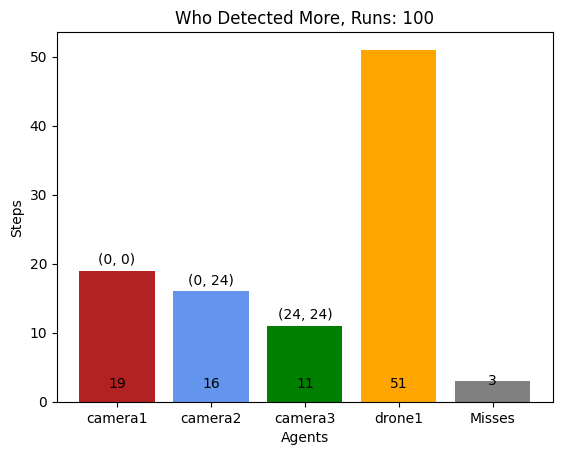

In [295]:
positions = []

def run_simulation(runs):
  detections = {}

  model = DroneModel(parameters)

  counter = 1
  for camera in range(parameters['cameras']):
    id = "camera" + str(counter)
    detections[id] = 0
    counter += 1

  counter = 1
  for drone in range(parameters['drones']):
    id = "drone" + str(counter)
    detections[id] = 0
    counter += 1

  for i in range(runs):
    model = DroneModel(parameters)
    results = model.run()
    data = results.variables.DroneModel
    if data['whoDetected'][model.steps] != None:
      detections[data['whoDetected'][model.steps]] += 1

  for agent in model.grid.agents:
    if agent.agentType == 0:
      positions.append(model.grid.positions[agent])

  print(positions)
  print(detections)
  return detections


def plot_dections(detections, positions):
  colors = ['firebrick', 'cornflowerblue', 'green', 'orange', 'indigo']
  # Create a list to store the numerical index for each detection
  index = 0
  for detection in detections:
    # Use the numerical index to access the color from the list
    plt.bar(detection, detections[detection], color=colors[index])
    #plt.text(index, detections[detection] + 0.5, str(detections[detection]), ha='center')
    plt.text(index, 2, str(detections[detection]), ha='center')
    if index < len(positions):
      plt.text(index, detections[detection] + 1, str(positions[index]),ha='center' )
    # Increment the index for the next detection
    index += 1


  plt.bar("Misses", runs - sum(detections.values()), color='gray')
  plt.text(index, 2 + 0.5, str(runs - sum(detections.values())), ha='center')

  plt.xlabel('Agents')
  plt.ylabel('Steps')
  plt.title(f'Who Detected More, Runs: {runs}')
  plt.show()

runs = 100
detections = run_simulation(runs)
plot_dections(detections, positions)